# Re Evaluate the data

In [100]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek

import toad
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


## Load Data

In [2]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [3]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [4]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [5]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [6]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [7]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [8]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [9]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [10]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [11]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
1056375,363510,0,Revolving loans,M,Y,N,0,126000.0,270000.0,13500.0,270000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.004960,-15260,-833,-9062.0,-4575,1,1,0,1,0,0,2.0,2,2,TUESDAY,13,0,0,0,0,0,0,Housing,0.645869,2.0,0.0,2.0,0.0,-625.0,370235.70,143132.49,1987509.0,Consumer loans,19390.725,157365.00,168615.00,157365.00,SUNDAY,16.0,Y,1.0,XAP,Approved,-625.0,Cash through the bank,XAP,New,Computers,POS,XNA,Country-wide,144.0,Consumer electronics,10.0,middle,POS household with interest,-323.0,213294.870,193904.145,19390.725,NaN,NaN,0.0
108919,127378,0,Cash loans,F,Y,N,0,225000.0,450000.0,46242.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018850,-15913,-2700,-3018.0,-4273,1,1,1,1,0,0,2.0,2,2,TUESDAY,19,0,0,0,0,0,0,Business Entity Type 3,0.551989,4.0,0.0,4.0,0.0,-329.0,NaN,NaN,2751327.0,Cash loans,35935.380,360000.00,379008.00,360000.00,THURSDAY,9.0,Y,1.0,Other,Approved,-325.0,Cash through the bank,XAP,New,XNA,Cash,walk-in,Credit and cash offices,-1.0,XNA,12.0,low_normal,Cash Street: low,365243.0,323470.125,359642.745,-36172.620,NaN,NaN,0.0
1362388,439426,0,Cash loans,M,N,N,1,126000.0,247500.0,26784.0,247500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,0.004960,-12566,-2351,-3018.0,-3015,1,1,0,1,0,0,3.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.588911,0.0,0.0,0.0,0.0,-1142.0,NaN,NaN,1475945.0,Cash loans,0.000,0.00,0.00,0.00,THURSDAY,14.0,Y,1.0,XNA,Canceled,-216.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Cash,0.0,NaN,NaN,NaN,NaN,NaN,NaN
391208,197780,0,Cash loans,F,Y,N,0,112500.0,450000.0,27531.0,450000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.010500,-21878,365243,-5573.0,-5094,1,0,0,1,0,0,2.0,3,3,SATURDAY,10,0,0,0,0,0,0,XNA,0.535695,0.0,0.0,0.0,0.0,-410.0,1398910.50,126634.50,2063587.0,Cash loans,44964.000,450000.00,450000.00,450000.00,FRIDAY,10.0,Y,1.0,XNA,Approved,-835.0,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Stone,70.0,Consumer electronics,12.0,middle,Cash X-Sell: middle,-475.0,584368.830,539404.830,44964.000,NaN,NaN,0.0
692658,273357,0,Cash loans,M,Y,N,0,270000.0,450000.0,27324.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.028663,-14706,-7158,-152.0,-4501,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,8,0,0,0,0,1,1,Other,0.574482,0.0,0.0,0.0,0.0,-1222.0,18439690.50,492846.48,1106304.0,Consumer loans

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


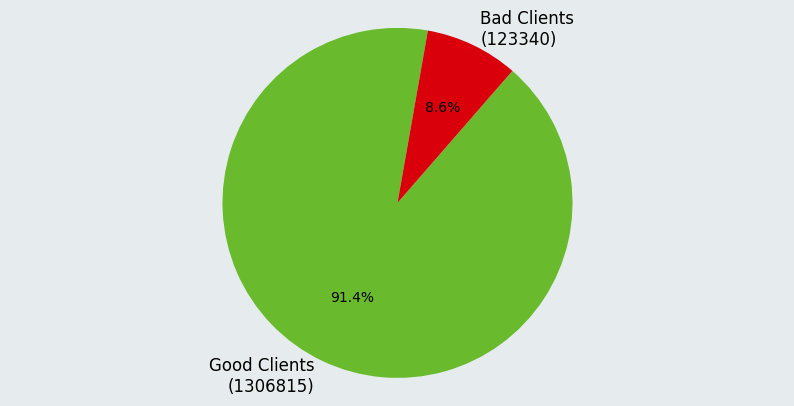

In [12]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()

As we can see that Clients in our data is Dominated by Good Clients whose don't have payment difficulties. This also mean that our data class is imbalance, we have to handle this imbalance data later on.

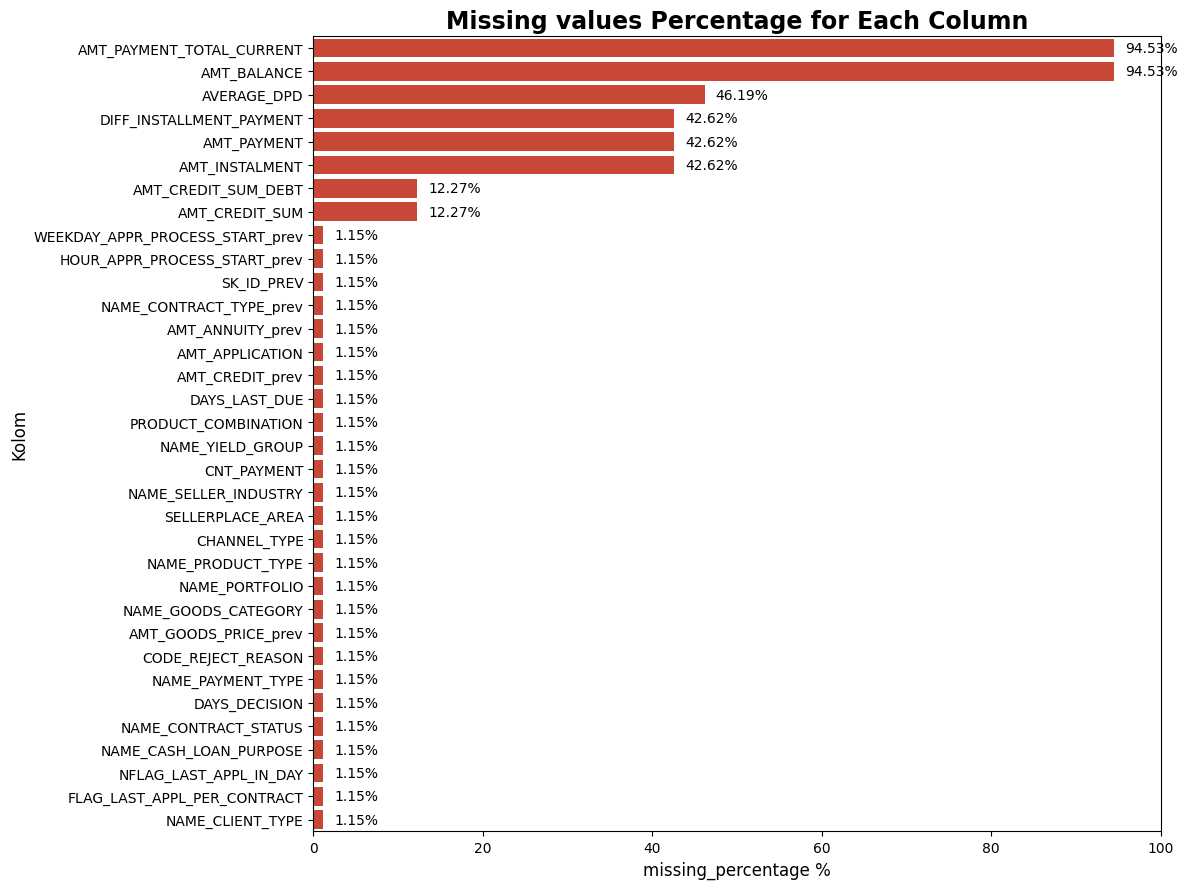

In [13]:
ms.plot_missing_percentage(train_full)

## Oulier Cheking

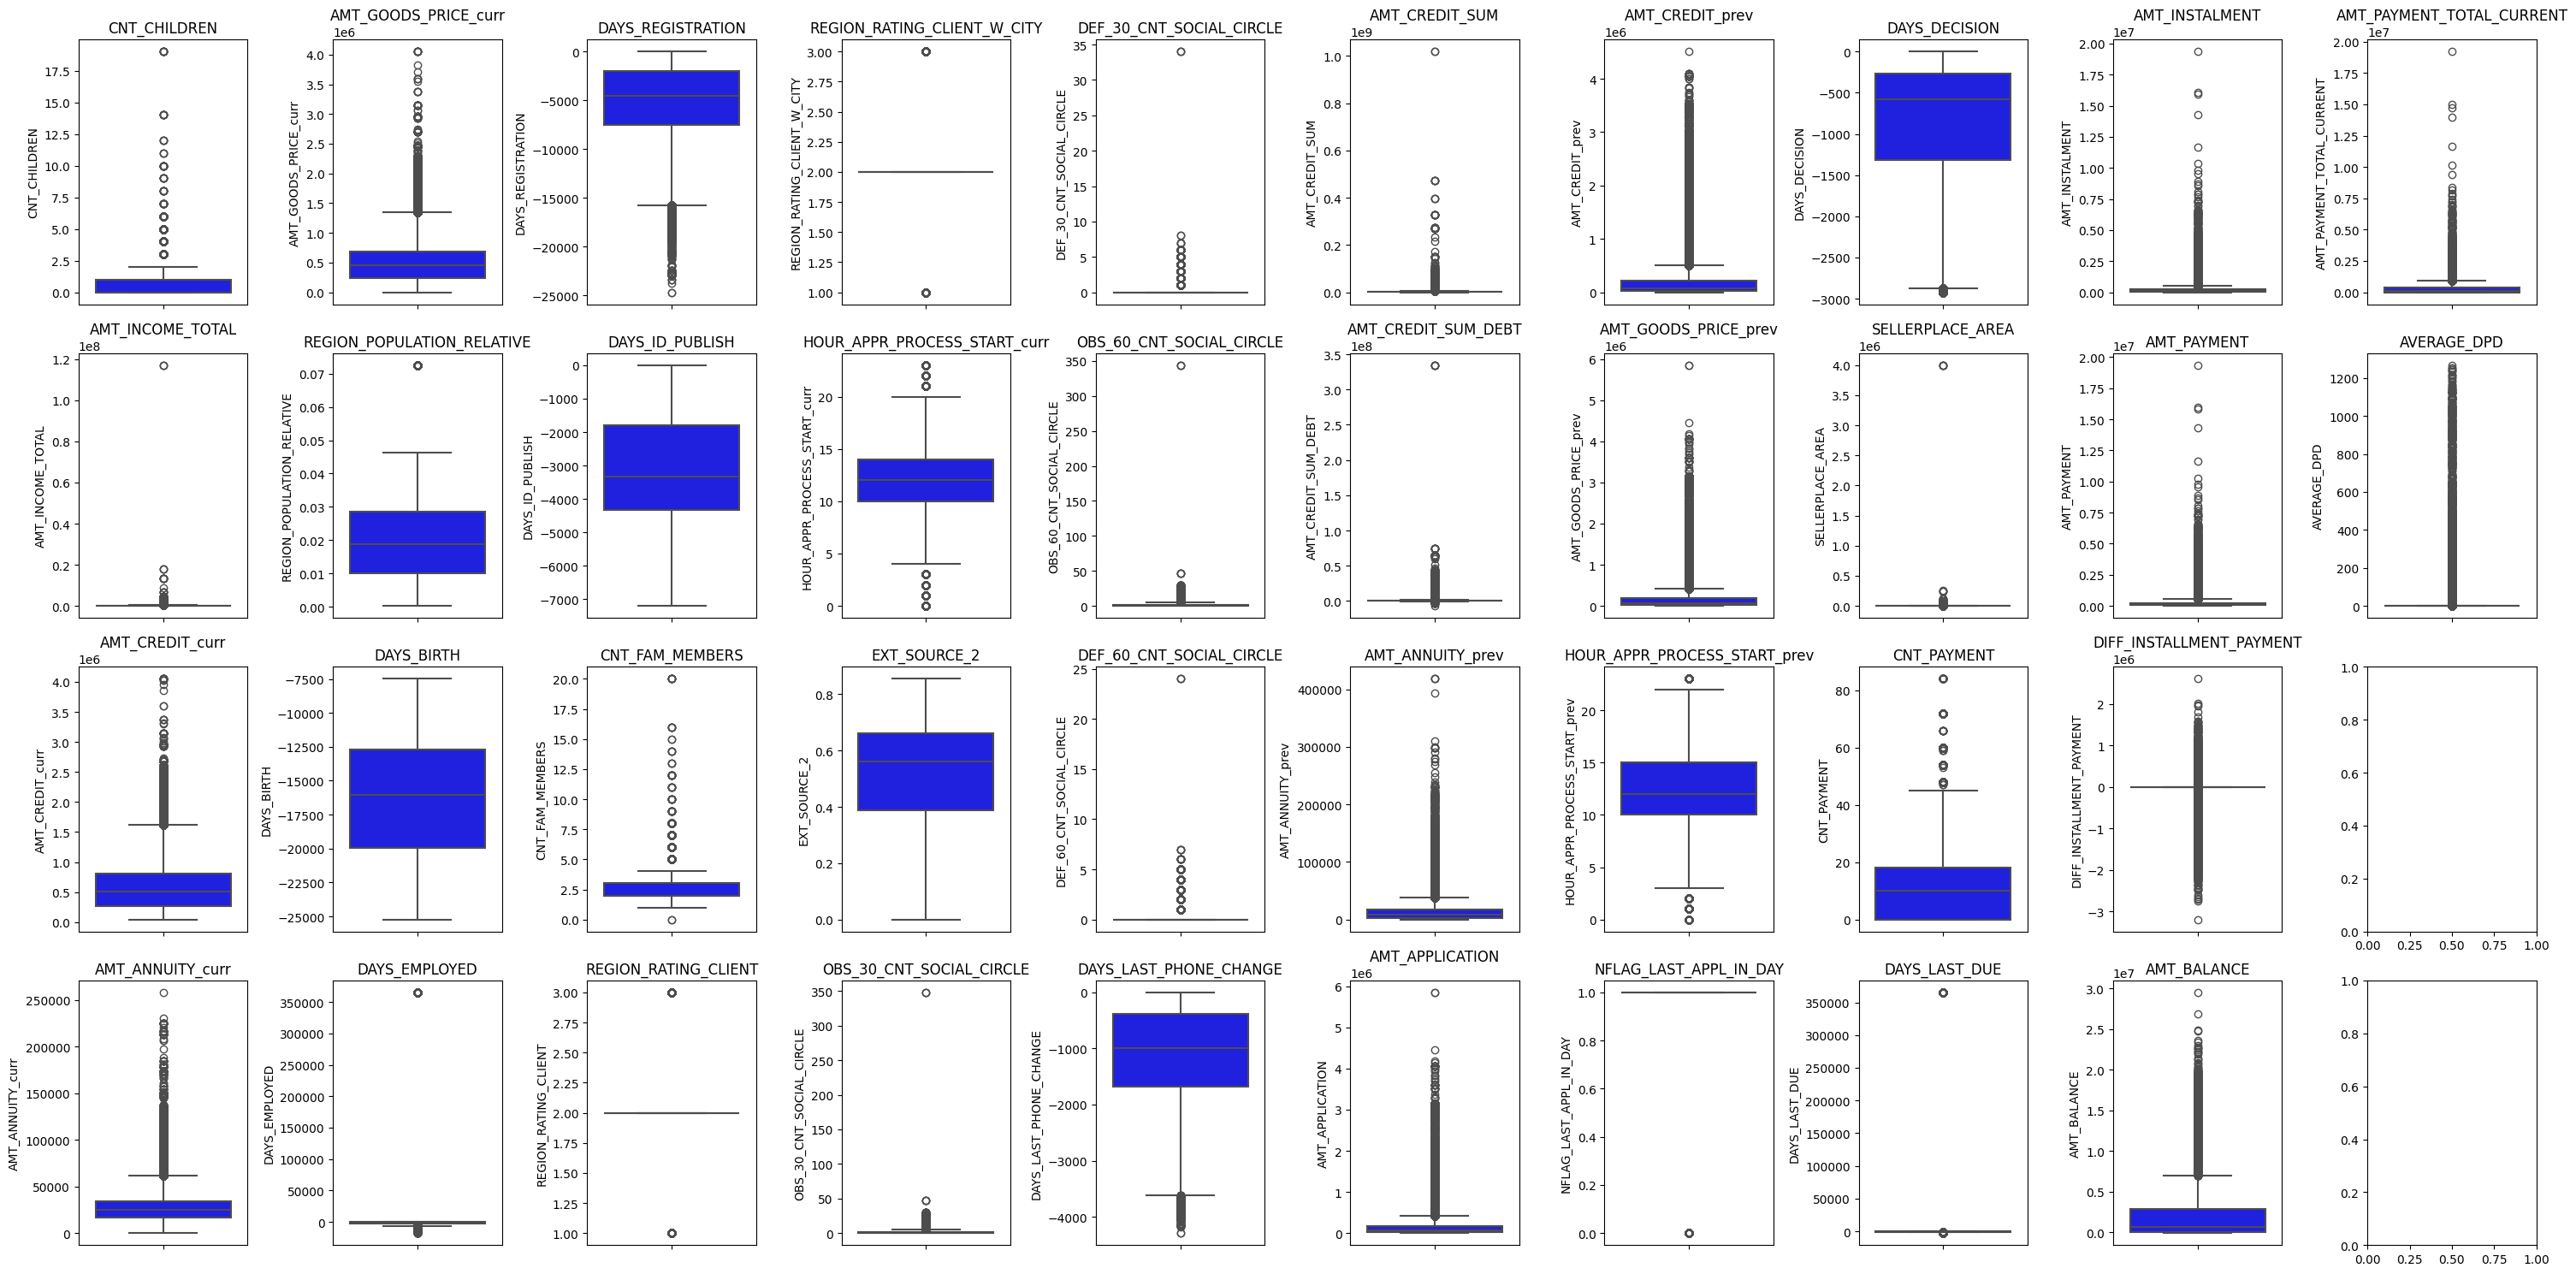

In [14]:
numvisual = train_full[[
    'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
    'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
    'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
    'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
    'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
    'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
    'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
    'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
    'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
    'AVERAGE_DPD'
          ]].copy()

colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# Create a 9x4 grid of subplots
fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# for each group of 4 columns
for i, group in enumerate(colgroup):
    # For eachg column in the group
    for j, column in enumerate(group):
        # Create a boxplot for the apporopriate subplot
        sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
        axs[j, i].set_title(column)

# show plot
plt.tight_layout()
plt.show()

## Train Test Split

In [156]:
X = train_full.drop(columns=['TARGET', 'SK_ID_CURR', 'SK_ID_PREV'], axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)


## Handle Missing Values

In [147]:
# X train missing values handling
X_train_c1 = X_train.AVERAGE_DPD.fillna(0)
X_train_c2 = ms.dropnan(X_train, 0.4)

train_missing = X_train_c2[X_train_c2.columns[X_train_c2.isna().any()]] 
traincol = train_missing.columns

for col in traincol:
    if X_train_c2[col].dtype == 'object':
        X_train_c2[col].fillna(X_train_c2[col].mode()[0], inplace=True)
    else:
        X_train_c2[col].fillna(X_train_c2[col].median(), inplace=True)


# X test missing values handling
X_test_c1 = X_test.AVERAGE_DPD.fillna(0)
X_test_c2 = ms.dropnan(X_test, 0.4)

test_missing = X_test_c2[X_test_c2.columns[X_test_c2.isna().any()]]
testcol = test_missing.columns

for col in testcol:
    if X_test_c2[col].dtype == 'object':
        X_test_c2[col].fillna(X_test_c2[col].mode()[0], inplace=True)
    else:
        X_test_c2[col].fillna(X_test_c2[col].median(), inplace=True)

## Handling Outlier

In [162]:
def cap_outliers(data, columns):
    # Create a copy of the data to avoid modifying the original DataFrame
    result = data.copy()

    # Loop over each column in the provided list
    for col in columns:
        # Calculate the first quartile (Q1) for the current column
        Q1 = result[col].quantile(0.25)
        # Calculate the third quartile (Q3) for the current column
        Q3 = result[col].quantile(0.75)
        # Calculate the Interquartile Range (IQR) for the current column
        IQR = Q3 - Q1
        # Calculate the lower bound for the current column
        lower_bound = Q1 - (1.5 * IQR)
        # Calculate the upper bound for the current column
        upper_bound = Q3 + (1.5 * IQR)
        # Replace values in the current column that are less than the lower bound with the lower bound
        result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
        # Replace values in the current column that are greater than the upper bound with the upper bound
        result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
    # Return the DataFrame with capped outliers
    return result

In [163]:
# Select the names of all numerical columns in the DataFrame X_train_c2
outliers = X_train_c2.select_dtypes(include='number').columns

# Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# This will cap the outliers in these columns, and the result is stored in X_train_c3
X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [164]:
# x train categorical value binning
X_train_c3['AGE'] = round(abs(X_train_c3['DAYS_BIRTH'] / 365.25)).astype(int)

X_train_c3 = X_train_c3[X_train_c2.NAME_FAMILY_STATUS != 'Unknown']
y_train = y_train.drop([194676, 868956])
X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                      'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE'], axis=1)

# replace abnormal value
replace_val = {4.5 : 5,
               0.5 : 1}
X_train_c3['CNT_FAM_MEMBERS'] = X_train_c3['CNT_FAM_MEMBERS'].replace(replace_val)

# replace not defined value as nan
replace_nan = {'XNA': np.nan}
train_full['NAME_YIELD_GROUP'] = train_full['NAME_YIELD_GROUP'].replace(replace_nan)

mapping_dict = {'Family' : 'Companied',
                'Spouse, partner': 'Companied',
                'Children': 'Companied',
                'Other_A': 'Companied',
                'Other_B': 'Companied',
                'Group of people': 'Companied'}
X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

map_income_val = {'Unemployed': 'Others', 
                  'Student': 'Others', 
                  'Materniity leave': 'Others',
                  'Businessman': 'Others'}

X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# x test categorical value binning
X_test_c3 = X_test_c2.copy()
X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                    'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

X_test_c3['NAME_YIELD_GROUP'] = X_test_c3['NAME_YIELD_GROUP'].replace(replace_nan)

X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Selection

In [154]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(X_train_c3, y_train['TARGET'])
df_iv.sort_values('iv', ascending=False).head(30)

,name,iv
0,EXT_SOURCE_2,0.286951
1,DAYS_EMPLOYED,0.097368
2,AMT_GOODS_PRICE_curr,0.091099
3,DAYS_BIRTH,0.077279
4,AGE,0.076931
5,AMT_CREDIT_SUM_DEBT,0.065827
6,AMT_CREDIT_curr,0.057496
7,DAYS_LAST_PHONE_CHANGE,0.056032
8,NAME_INCOME_TYPE,0.055802
9,REGION_POPULATION_RELATIVE,0.042513


In [165]:
X_train_selected, drop_list = toad.selection.select(frame=X_train_c3,
                                                  target=y_train['TARGET'],
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",X_train_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(X_train_selected)
print(f'\n{drop_list}')

keep: 15 drop empty: 0 drop iv: 45 drop corr: 4


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,CNT_PAYMENT,DAYS_LAST_DUE
929990,F,171000.0,Pensioner,Higher education,0.022800,-21310.0,3528.0,-9977.0,-4143.0,0.147803,-119.0,20045.880,Canceled,0.0,0.0
299559,M,900000.0,State servant,Secondary / secondary special,0.006305,-21609.0,-1010.0,-12360.0,-4790.0,0.492229,-954.0,204322.500,Canceled,0.0,0.0
428457,F,1341000.0,Working,Secondary / secondary special,0.011703,-19394.0,-2579.0,-11456.0,-2943.0,0.688937,-2003.0,0.000,Canceled,0.0,0.0
7003,M,225000.0,Working,Incomplete higher,0.018801,-9142.0,-746.0,-4016.0,-1805.0,0.402901,-1393.0,46462.500,Approved,6.0,-1212.0
412202,M,270000.0,Working,Secondary / secondary special,0.019689,-12550.0,-1764.0,-3255.0,-3867.0,0.182729,-153.0,0.000,Approved,6.0,-221.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,F,270000.0,Commercial associate,Incomplete higher,0.031329,-10380.0,-921.0,-4866.0,-3042.0,0.444848,-954.0,69386.355,Approved,6.0,-1832.5
1419947,F,405000.0,Pensioner,Secondary / secondary special,0.025164,-20659.0,3528.0,-4696.0,-4150.0,0.194499,-593.0,108.000,Canceled,0.0,0.0
734247,F,801000.0,State servant,Secondary / secondary special,0.015221,-14070.0,-6632.0,-8163.0,-5151.0,0.499346,-1110.0,49782.240,Canceled,0.0,0.0
509863,F,409500.0,Commercial associate,Secondary / secondary special,0.002134,-10528.0,-342.0,-4236.0,-185.0,0.239021,-872.0,199368.000,Refused,12.0,0.0



{'empty': array([], dtype=float64), 'iv': array(['NAME_CONTRACT_TYPE_curr', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START_curr', 'HOUR_APPR_PROCESS_START_curr',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_CREDIT_SUM', 'NAME_CONTRACT_TYPE_prev', 'AMT_ANNUITY_prev',
       'AMT_APPLICATION', 'AMT_CREDIT_prev', 'AMT_GOODS_PRICE_prev',
       'WEEKDAY_APPR_PROCESS_START_prev', 'HOUR_AP

In [166]:
selected_features = X_train_selected.columns

X_test_selected = X_test_c3[selected_features]

## Feature Encoding

In [167]:
cat_col = X_train_selected.select_dtypes('object').columns
cat_col

Index(['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_CONTRACT_STATUS'],
      dtype='object')

because all our categorical variables data is nominal, we will use one hot encoding to encode our categorical variables.

In [178]:
# function to create dummy variables
def dummy_creation(data, cols_list):
    data_dummies = []
    for col in cols_list:
        data_dummies.append(pd.get_dummies(data[col], prefix=col, prefix_sep=':', drop_first=True).astype(int))
    data_dummies = pd.concat(data_dummies, axis=1)
    data = pd.concat([data, data_dummies], axis=1)
    return data

# apply the function to X_train_c3
X_train_c3 = dummy_creation(X_train_selected, cat_col)
X_train_c3 = X_train_c3.drop(columns=cat_col, axis=1)

# apply the function to X_test_c3
X_test_c3 = dummy_creation(X_test_selected, cat_col)
X_test_c3 = X_test_selected.drop(columns=cat_col, axis=1)

In [177]:
X_train_c3

,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,CNT_PAYMENT,DAYS_LAST_DUE,CODE_GENDER:M,CODE_GENDER:XNA,NAME_INCOME_TYPE:Maternity leave,NAME_INCOME_TYPE:Others,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_CONTRACT_STATUS:Canceled,NAME_CONTRACT_STATUS:Refused,NAME_CONTRACT_STATUS:Unused offer
929990,171000.0,0.022800,-21310.0,3528.0,-9977.0,-4143.0,0.147803,-119.0,20045.880,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
299559,900000.0,0.006305,-21609.0,-1010.0,-12360.0,-4790.0,0.492229,-954.0,204322.500,0.0,0.0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
428457,1341000.0,0.011703,-19394.0,-2579.0,-11456.0,-2943.0,0.688937,-2003.0,0.000,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
7003,225000.0,0.018801,-9142.0,-746.0,-4016.0,-1805.0,0.402901,-1393.0,46462.500,6.0,-1212.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
412202,270000.0,0.019689,-12550.0,-1764.0,-3255.0,-3867.0,0.182729,-153.0,0.000,6.0,-221.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,270000.0,0.031329,-10380.0,-921.0,-4866.0,-3042.0,0.444848,-954.0,69386.355,6.0,-1832.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1419947,405000.0,0.025164,-20659.0,3528.0,-4696.0,-4150.0,0.194499,-593.0,108.000,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
734247,801000.0,0.015221,-14070.0,-6632.0,-8163.0,-5151.0,0.499346,-1110.0,49782.240,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
509863,409500.0,0.002134,-10528.0,-342.0,-4236.0,-185.0,0.239021,-872.0,199368.000,12.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


## Feature Scaling

In [220]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_c4)

# X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [221]:
# stomek = SMOTETomek(random_state=1103)
# X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

## WoE Binning and Feature Engineering

### discrete feature

In [179]:
# make woe discretize function
def discrete_woe(data, cat_var, y_data):
    data = pd.concat([data[cat_var], y_data], axis=1)
    data = pd.concat([data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].count(),
                      data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].mean()], axis=1)
    data = data.iloc[:, [0, 1, 3]]
    data.columns = [data.columns.values[0], 'n_obs', 'prop_good']
    data['prop_n_obs'] = data['n_obs'] / data['n_obs'].sum()
    data['n_good'] = data['prop_good'] * data['n_obs']
    data['n_bad'] = (1 - data['prop_good']) * data['n_obs']
    data['prop_n_good'] = data['n_good'] / data['n_good'].sum()
    data['prop_n_bad'] = data['n_bad'] / data['n_bad'].sum()
    data['WoE'] = np.log(data['prop_n_good'] / data['prop_n_bad'])
    data = data.sort_values(['WoE'])
    data = data.reset_index(drop=True)
    data['diff_prop_good'] = data['prop_good'].diff().abs()
    data['diff_WoE'] = data['WoE'].diff().abs()
    data['IV'] = (data['prop_n_good'] - data['prop_n_bad']) * data['WoE']
    data['IV'] = data['IV'].sum()
    return data

In [180]:
# plot woe function 
def plot_woe(data_woe):
    x = np.array(data_woe.iloc[:, 0].apply(str))
    y = data_woe['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker='o', linestyle='--', color='k')
    plt.xlabel(data_woe.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title('Weight of Evidence by' + data_woe.columns[0])
    plt.xticks(rotation=0)

In [181]:
X_train_c3

,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,CNT_PAYMENT,DAYS_LAST_DUE,CODE_GENDER:M,CODE_GENDER:XNA,NAME_INCOME_TYPE:Maternity leave,NAME_INCOME_TYPE:Others,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_CONTRACT_STATUS:Canceled,NAME_CONTRACT_STATUS:Refused,NAME_CONTRACT_STATUS:Unused offer
929990,171000.0,0.022800,-21310.0,3528.0,-9977.0,-4143.0,0.147803,-119.0,20045.880,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
299559,900000.0,0.006305,-21609.0,-1010.0,-12360.0,-4790.0,0.492229,-954.0,204322.500,0.0,0.0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
428457,1341000.0,0.011703,-19394.0,-2579.0,-11456.0,-2943.0,0.688937,-2003.0,0.000,0.0,0.0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
7003,225000.0,0.018801,-9142.0,-746.0,-4016.0,-1805.0,0.402901,-1393.0,46462.500,6.0,-1212.0,1,0,0,0,0,0,1,0,1,0,0,0,0,0
412202,270000.0,0.019689,-12550.0,-1764.0,-3255.0,-3867.0,0.182729,-153.0,0.000,6.0,-221.0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,270000.0,0.031329,-10380.0,-921.0,-4866.0,-3042.0,0.444848,-954.0,69386.355,6.0,-1832.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1419947,405000.0,0.025164,-20659.0,3528.0,-4696.0,-4150.0,0.194499,-593.0,108.000,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
734247,801000.0,0.015221,-14070.0,-6632.0,-8163.0,-5151.0,0.499346,-1110.0,49782.240,0.0,0.0,0,0,0,0,0,1,0,0,0,0,1,1,0,0
509863,409500.0,0.002134,-10528.0,-342.0,-4236.0,-185.0,0.239021,-872.0,199368.000,12.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


### continuous feature

In [183]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [184]:
# function to woe continuous variable
def woe_continous(data, continous_col, y_data):
    data = pd.concat([data[continous_col], y_data], axis=1)
    data = pd.concat([data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].count(),
                      data.groupby(data.columns.values[0], as_index=False)[data.columns.values[1]].mean()], axis=1)
    data = data.iloc[:, [0, 1, 3]]
    data.columns = [data.columns.values[0], 'n_obs', 'prop_good']
    data['prop_n_obs'] = data['n_obs'] / data['n_obs'].sum()
    data['n_good'] = data['prop_good'] * data['n_obs']
    data['n_bad'] = (1 - data['prop_good']) * data['n_obs']
    data['prop_n_good'] = data['n_good'] / data['n_good'].sum()
    data['prop_n_bad'] = data['n_bad'] / data['n_bad'].sum()
    data['WoE'] = np.log(data['prop_n_good'] / data['prop_n_bad'])
    data = data.sort_values(['WoE'])
    data = data.reset_index(drop=True)
    data['diff_prop_good'] = data['prop_good'].diff().abs()
    data['diff_WoE'] = data['WoE'].diff().abs()
    data['IV'] = (data['prop_n_good'] - data['prop_n_bad']) * data['WoE']
    data['IV'] = data['IV'].sum()
    return data


#### AMT_GOODS_PRICE

,AMT_GOODS_PRICE_curr,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(1206900.0, 1341000.0]",54215,0.056553,0.050545,3066.0,51149.0,0.033130,0.052189,-0.454429,NaN,NaN,0.039916
1,"(1072800.0, 1206900.0]",48735,0.060511,0.045436,2949.0,45786.0,0.031866,0.046717,-0.382572,0.003958,0.071857,0.039916
2,"(938700.0, 1072800.0]",21277,0.063637,0.019837,1354.0,19923.0,0.014631,0.020328,-0.328872,0.003126,0.053701,0.039916
3,"(-1341.0, 134100.0]",53791,0.069993,0.050149,3765.0,50026.0,0.040683,0.051043,-0.226855,0.006356,0.102017,0.039916
4,"(804600.0, 938700.0]",89305,0.072471,0.083259,6472.0,82833.0,0.069934,0.084517,-0.189402,0.002478,0.037454,0.039916
5,"(670500.0, 804600.0]",141427,0.078168,0.131853,11055.0,130372.0,0.119457,0.133023,-0.107569,0.005697,0.081832,0.039916
6,"(536400.0, 670500.0]",64448,0.084207,0.060085,5427.0,59021.0,0.058642,0.060221,-0.026567,0.006040,0.081002,0.039916
7,"(134100.0, 268200.0]",255478,0.087377,0.238183,22323.0,233155.0,0.241215,0.237896,0.013854,0.003170,0.040421,0.039916
8,"(268200.0, 402300.0]",134697,0.101049,0.125578,13611.0,121086.0,0.147076,0.123548,0.174317,0.013672,0.160463,0.039916
9,"(402300.0, 536400.0]",209241,0.107637,0.195076,22522.0,186719.0,0.243365,0.190516,0.244828,0.006588,0.070511,0.039916


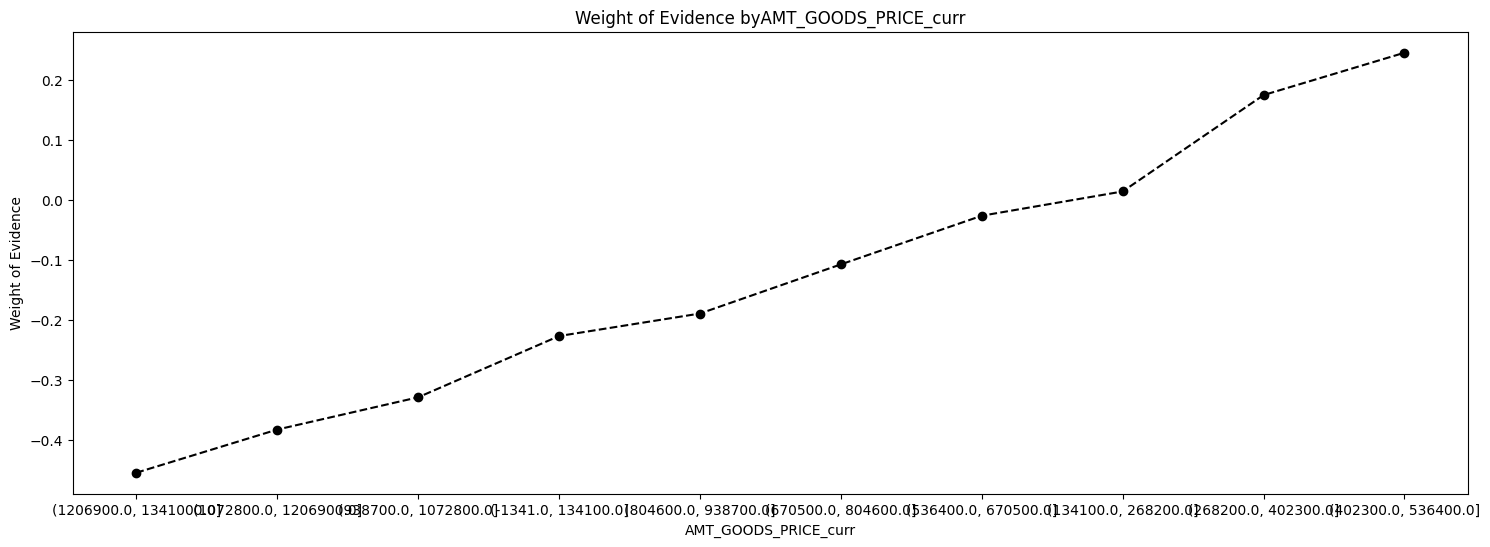

In [185]:
X_train_c4 = X_train_c3.copy()
# fine cut of AMT_INCOME_TOTAL
X_train_c4['AMT_GOODS_PRICE_curr'] = pd.cut(X_train_c4['AMT_GOODS_PRICE_curr'], bins=10)

tempdata = woe_continous(X_train_c4, 'AMT_GOODS_PRICE_curr', y_train)
display(tempdata)
plot_woe(tempdata)

#### REGION_POPULATION_RELATIVE

,REGION_POPULATION_RELATIVE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.0453, 0.0566]",69460,0.049050,0.064758,3407.0,66053.0,0.036815,0.067396,-0.604686,NaN,NaN,0.026345
1,"(0.0341, 0.0453]",55897,0.073224,0.052113,4093.0,51804.0,0.044228,0.052857,-0.178249,0.024174,0.426436,0.026345
2,"(0.0228, 0.0341]",260113,0.081284,0.242504,21143.0,238970.0,0.228464,0.243830,-0.065089,0.008060,0.113160,0.026345
3,"(0.000234, 0.0116]",333431,0.089941,0.310858,29989.0,303442.0,0.324051,0.309613,0.045580,0.008657,0.110669,0.026345
4,"(0.0116, 0.0228]",353713,0.095874,0.329767,33912.0,319801.0,0.366442,0.326304,0.116010,0.005934,0.070430,0.026345


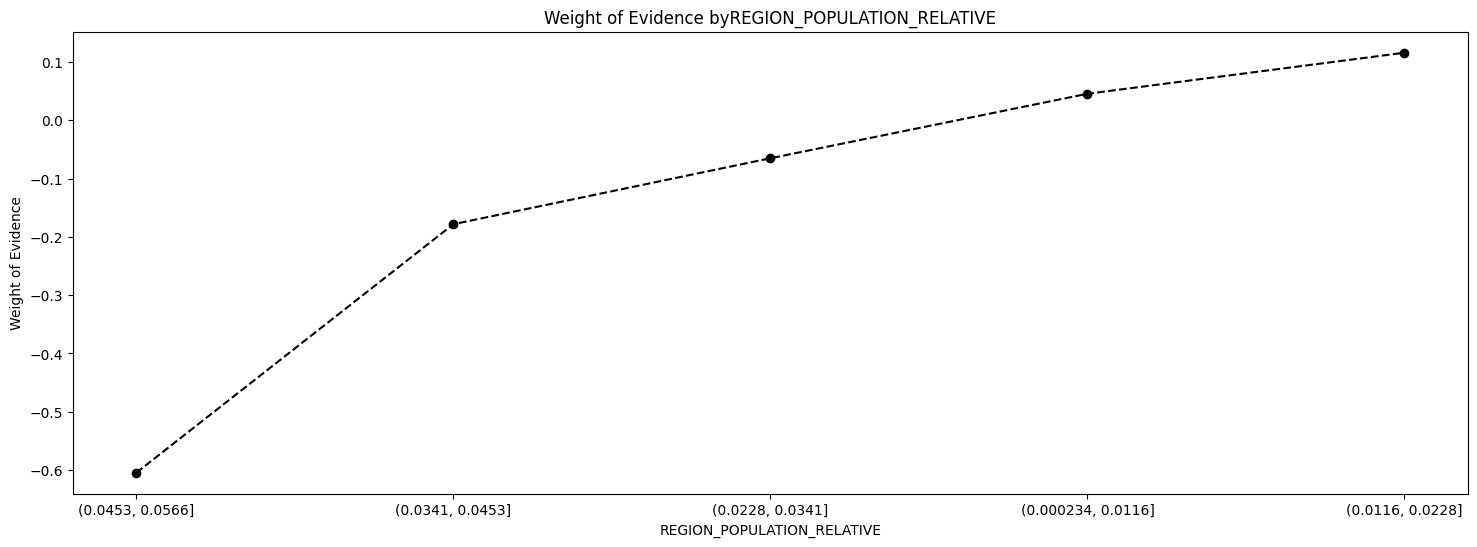

In [186]:
# fine cut of REGION_POPULATION_RELATIVE
X_train_c4['REGION_POPULATION_RELATIVE'] = pd.cut(X_train_c4['REGION_POPULATION_RELATIVE'], bins=5)
tempdata = woe_continous(X_train_c4, 'REGION_POPULATION_RELATIVE', y_train)
display(tempdata)
plot_woe(tempdata)

#### DAYS EMPLOYED

,DAYS_BIRTH,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-25246.74, -23455.0]",49274,0.044182,0.045938,2177.0,47097.0,0.023524,0.048055,-0.714322,NaN,NaN,0.074518
1,"(-23455.0, -21681.0]",105838,0.057531,0.098673,6089.0,99749.0,0.065796,0.101777,-0.436233,0.013350,0.278088,0.074518
2,"(-21681.0, -19907.0]",118276,0.063665,0.110269,7530.0,110746.0,0.081367,0.112998,-0.328404,0.006133,0.107829,0.074518
3,"(-19907.0, -18133.0]",115851,0.079464,0.108008,9206.0,106645.0,0.099477,0.108814,-0.089710,0.015799,0.238694,0.074518
4,"(-18133.0, -16359.0]",122877,0.081569,0.114558,10023.0,112854.0,0.108305,0.115149,-0.061273,0.002105,0.028438,0.074518
5,"(-16359.0, -14585.0]",143079,0.087923,0.133393,12580.0,130499.0,0.135935,0.133153,0.020682,0.006354,0.081955,0.074518
6,"(-14585.0, -12811.0]",143462,0.097238,0.133750,13950.0,129512.0,0.150739,0.132146,0.131646,0.009315,0.110963,0.074518
7,"(-12811.0, -11037.0]",130380,0.107731,0.121554,14046.0,116334.0,0.151776,0.118700,0.245812,0.010493,0.114166,0.074518
8,"(-11037.0, -9263.0]",108701,0.115657,0.101342,12572.0,96129.0,0.135849,0.098084,0.325721,0.007925,0.079909,0.074518
9,"(-9263.0, -7489.0]",34876,0.125330,0.032515,4371.0,30505.0,0.047232,0.031125,0.417041,0.009673,0.091320,0.074518


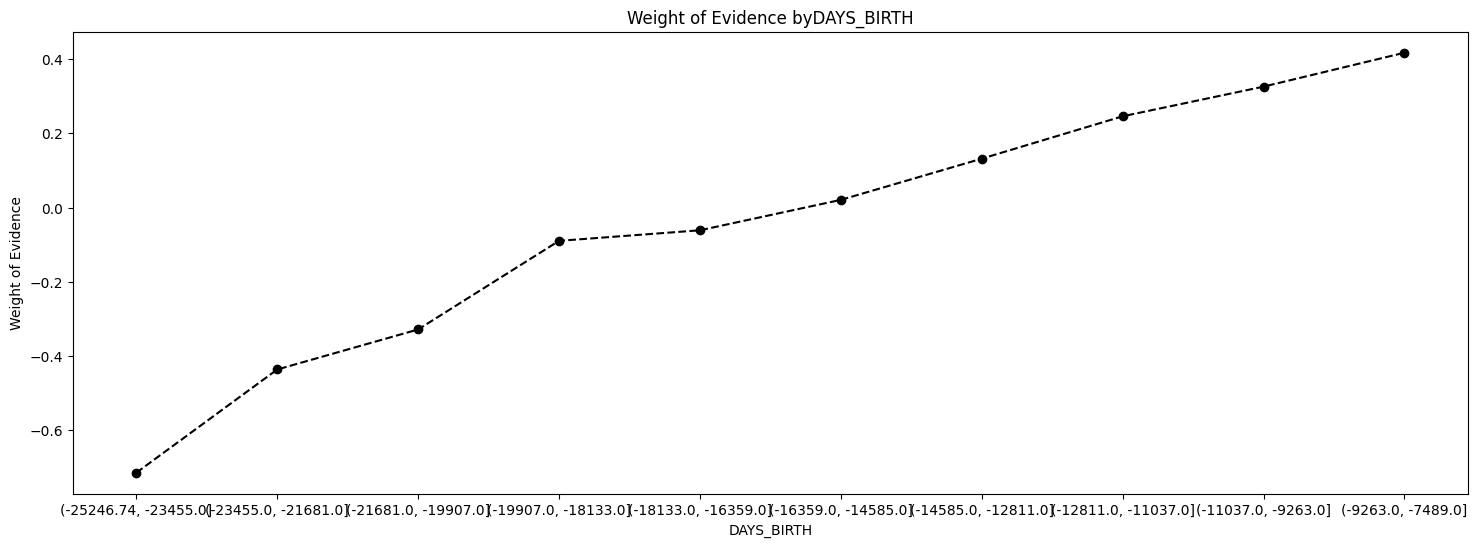

In [187]:
# fine cut of DAYS_BIRTH
X_train_c4['DAYS_BIRTH'] = pd.cut(X_train_c4['DAYS_BIRTH'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_BIRTH', y_train)
display(tempdata)
plot_woe(tempdata)

#### DAYS_BIRTH

,DAYS_EMPLOYED,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-6642.16, -5616.0]",76232,0.055121,0.071071,4202.0,72030.0,0.045405,0.073495,-0.481582,NaN,NaN,0.092366
1,"(2512.0, 3528.0]",207450,0.058886,0.193406,12216.0,195234.0,0.132002,0.199204,-0.411512,0.003765,0.070070,0.092366
2,"(-5616.0, -4600.0]",43554,0.061602,0.040605,2683.0,40871.0,0.028992,0.041702,-0.363545,0.002715,0.047967,0.092366
3,"(-4600.0, -3584.0]",65638,0.067278,0.061194,4416.0,61222.0,0.047718,0.062467,-0.269333,0.005676,0.094213,0.092366
4,"(-3584.0, -2568.0]",118109,0.076700,0.110113,9059.0,109050.0,0.097889,0.111268,-0.128108,0.009422,0.141225,0.092366
5,"(-2568.0, -1552.0]",173033,0.089746,0.161319,15529.0,157504.0,0.167801,0.160707,0.043198,0.013046,0.171306,0.092366
6,"(-1552.0, -536.0]",256027,0.112801,0.238694,28880.0,227147.0,0.312068,0.231766,0.297492,0.023055,0.254294,0.092366
7,"(-536.0, 480.0]",132571,0.117364,0.123596,15559.0,117012.0,0.168125,0.119391,0.342303,0.004563,0.044811,0.092366
8,"(480.0, 1496.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092366
9,"(1496.0, 2512.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092366


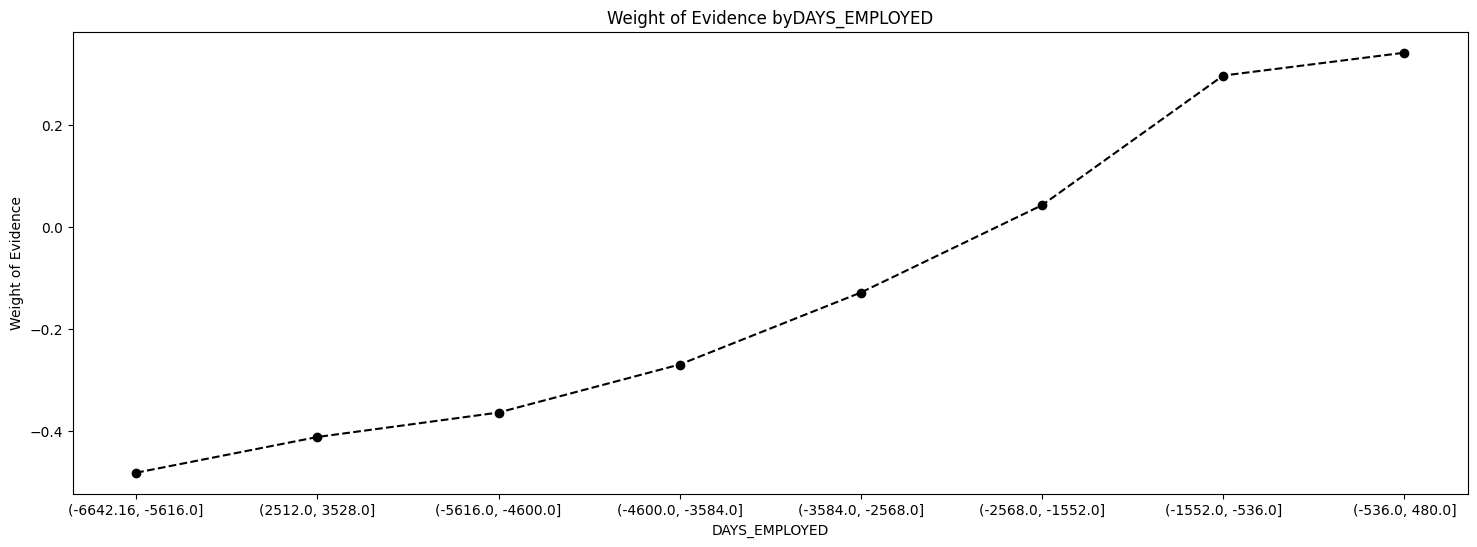

In [188]:
# fine cut of Days Employed
X_train_c4['DAYS_EMPLOYED'] = pd.cut(X_train_c4['DAYS_EMPLOYED'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_EMPLOYED', y_train)
display(tempdata)
plot_woe(tempdata)

,DAYS_REGISTRATION,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-15800.284, -14206.05]",8878,0.045055,0.008277,400.0,8478.0,0.004322,0.008650,-0.693826,NaN,NaN,0.025781
1,"(-14206.05, -12627.6]",20322,0.058951,0.018946,1198.0,19124.0,0.012945,0.019513,-0.410351,0.013896,0.283475,0.025781
2,"(-11049.15, -9470.7]",71401,0.063515,0.066567,4535.0,66866.0,0.049004,0.068226,-0.330926,0.004564,0.079425,0.025781
3,"(-12627.6, -11049.15]",36352,0.066104,0.033891,2403.0,33949.0,0.025966,0.034639,-0.288202,0.002589,0.042724,0.025781
4,"(-9470.7, -7892.25]",105131,0.076267,0.098014,8018.0,97113.0,0.086640,0.099088,-0.134246,0.010163,0.153955,0.025781
5,"(-7892.25, -6313.8]",117809,0.078534,0.109834,9252.0,108557.0,0.099974,0.110765,-0.102496,0.002267,0.031751,0.025781
6,"(-6313.8, -4735.35]",148084,0.087869,0.138059,13012.0,135072.0,0.140603,0.137819,0.020004,0.009335,0.122500,0.025781
7,"(-4735.35, -3156.9]",172941,0.090545,0.161233,15659.0,157282.0,0.169206,0.160480,0.052945,0.002676,0.032941,0.025781
8,"(-3156.9, -1578.45]",166671,0.091276,0.155388,15213.0,151458.0,0.164387,0.154538,0.061782,0.000730,0.008837,0.025781
9,"(-1578.45, 0.0]",225025,0.101562,0.209791,22854.0,202171.0,0.246953,0.206282,0.179952,0.010286,0.118170,0.025781


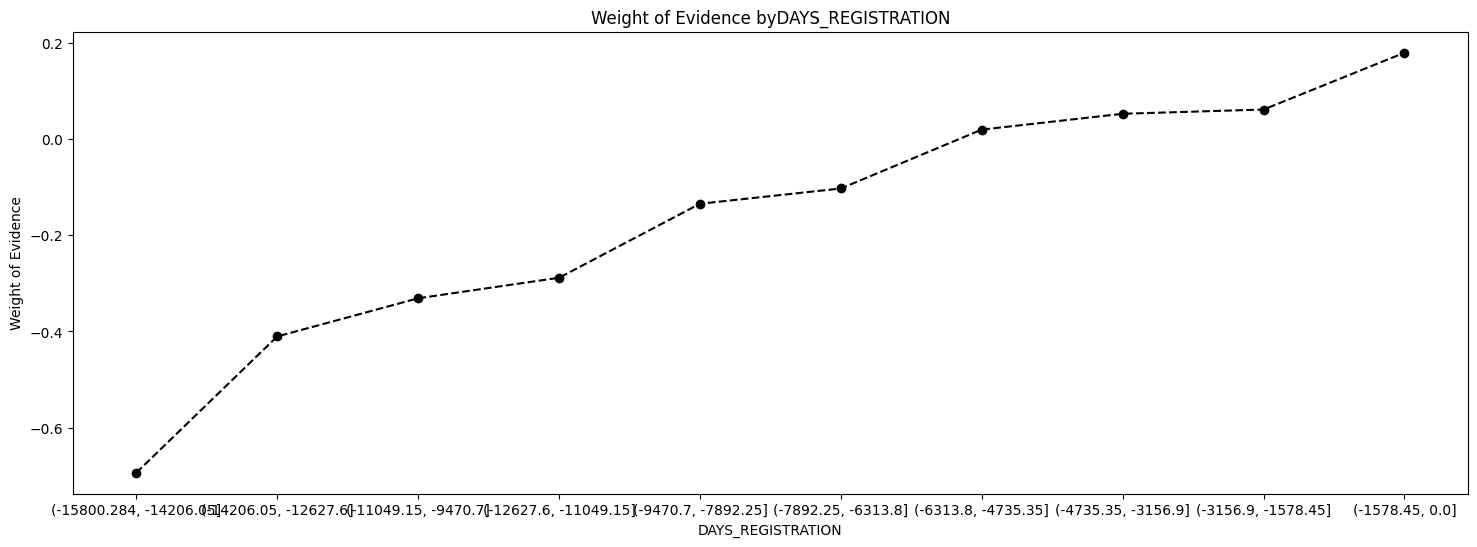

In [189]:
# fine cut of Days Registration
X_train_c4['DAYS_REGISTRATION'] = pd.cut(X_train_c4['DAYS_REGISTRATION'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_REGISTRATION', y_train)
display(tempdata)
plot_woe(tempdata)

,DAYS_ID_PUBLISH,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-7204.197, -6477.3]",4,0.000000,0.000004,0.0,4.0,0.000000,0.000004,-inf,NaN,NaN,inf
1,"(-6477.3, -5757.6]",4082,0.045321,0.003806,185.0,3897.0,0.001999,0.003976,-0.687667,0.045321,inf,inf
2,"(-5037.9, -4318.2]",228410,0.067423,0.212947,15400.0,213010.0,0.166407,0.217342,-0.267032,0.022102,0.420635,inf
3,"(-5757.6, -5037.9]",35829,0.068576,0.033403,2457.0,33372.0,0.026550,0.034051,-0.248836,0.001153,0.018195,inf
4,"(-4318.2, -3598.5]",217063,0.079157,0.202368,17182.0,199881.0,0.185663,0.203946,-0.093920,0.010581,0.154916,inf
5,"(-3598.5, -2878.8]",132110,0.083211,0.123166,10993.0,121117.0,0.118787,0.123580,-0.039559,0.004054,0.054362,inf
6,"(-2878.8, -2159.1]",127373,0.095907,0.118750,12216.0,115157.0,0.132002,0.117499,0.116390,0.012696,0.155948,inf
7,"(-2159.1, -1439.4]",111248,0.102006,0.103717,11348.0,99900.0,0.122623,0.101931,0.184812,0.006099,0.068422,inf
8,"(-719.7, 0.0]",104444,0.104477,0.097373,10912.0,93532.0,0.117911,0.095434,0.211499,0.002471,0.026688,inf
9,"(-1439.4, -719.7]",112051,0.105764,0.104465,11851.0,100200.0,0.128058,0.102238,0.225184,0.001287,0.013685,inf


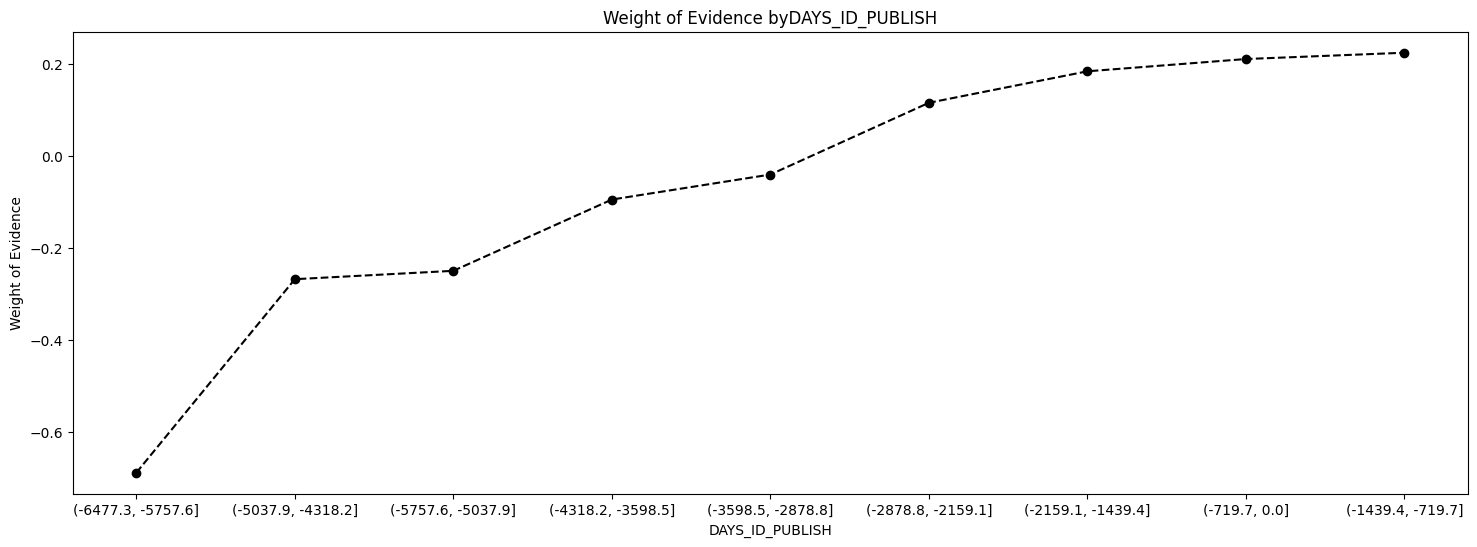

In [190]:
# fine cut of Days ID Publish
X_train_c4['DAYS_ID_PUBLISH'] = pd.cut(X_train_c4['DAYS_ID_PUBLISH'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_ID_PUBLISH', y_train)
display(tempdata)
plot_woe(tempdata)

#### EXT_SOURCE_2

,EXT_SOURCE_2,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(0.769, 0.855]",20419,0.025271,0.019037,516.0,19903.0,0.005576,0.020308,-1.292579,NaN,NaN,0.272815
1,"(0.684, 0.769]",180414,0.041843,0.168200,7549.0,172865.0,0.081572,0.176380,-0.771156,0.016572,0.521423,0.272815
2,"(0.598, 0.684]",246150,0.061268,0.229486,15081.0,231069.0,0.162960,0.235768,-0.369341,0.019425,0.401815,0.272815
3,"(0.513, 0.598]",189552,0.076955,0.176720,14587.0,174965.0,0.157622,0.178523,-0.124515,0.015688,0.244825,0.272815
4,"(0.427, 0.513]",123984,0.087882,0.115591,10896.0,113088.0,0.117739,0.115388,0.020169,0.010927,0.144685,0.272815
5,"(0.342, 0.427]",91563,0.104966,0.085364,9611.0,81952.0,0.103853,0.083619,0.216714,0.017084,0.196545,0.272815
6,"(0.256, 0.342]",80678,0.120008,0.075216,9682.0,70996.0,0.104621,0.072440,0.367585,0.015042,0.150870,0.272815
7,"(0.171, 0.256]",58547,0.141596,0.054583,8290.0,50257.0,0.089579,0.051279,0.557840,0.021588,0.190255,0.272815
8,"(0.0855, 0.171]",45653,0.170131,0.042562,7767.0,37886.0,0.083928,0.038656,0.775242,0.028536,0.217402,0.272815
9,"(-0.000855, 0.0855]",35654,0.240226,0.033240,8565.0,27089.0,0.092551,0.027640,1.208496,0.070094,0.433254,0.272815


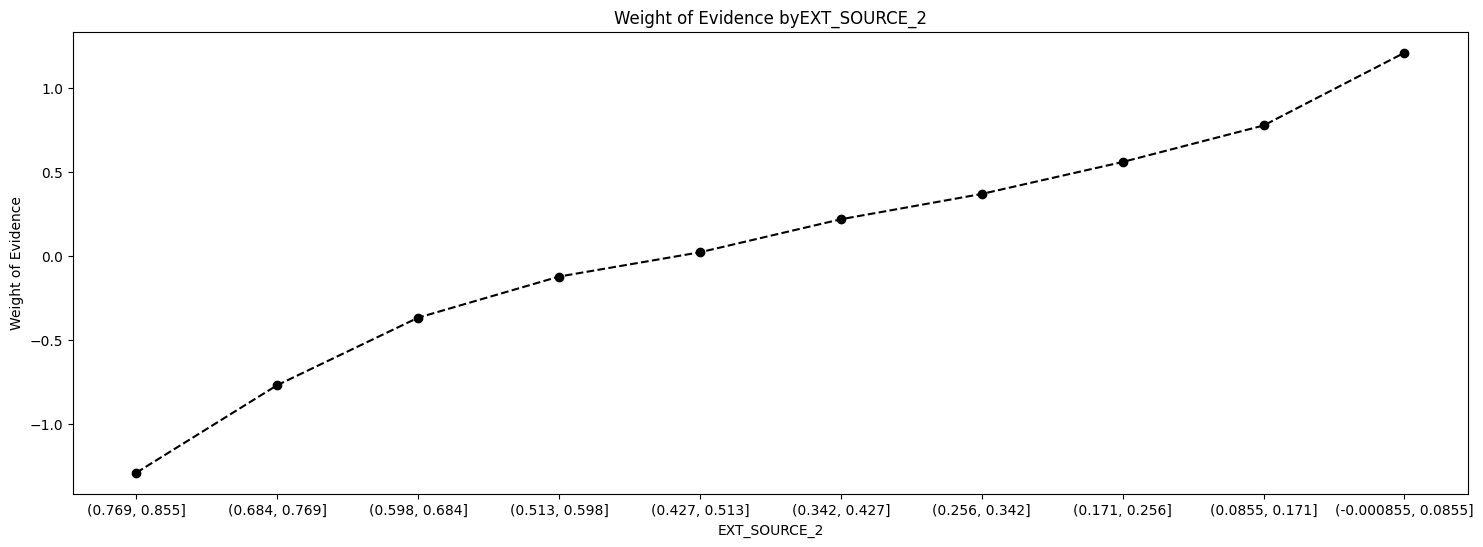

In [191]:
# fine cut of EXT_SOURCE_2
X_train_c4['EXT_SOURCE_2'] = pd.cut(X_train_c4['EXT_SOURCE_2'], bins=10)
tempdata = woe_continous(X_train_c4, 'EXT_SOURCE_2', y_train)
display(tempdata)
plot_woe(tempdata)

#### DAYS_LAST_PHONE_CHANGE

,DAYS_LAST_PHONE_CHANGE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-3624.12, -3258.45]",4818,0.049813,0.004492,240.0,4578.0,0.002593,0.004671,-0.588439,NaN,NaN,0.05023
1,"(-3258.45, -2896.4]",12342,0.052585,0.011506,649.0,11693.0,0.007013,0.011931,-0.531373,0.002771,0.057066,0.05023
2,"(-2896.4, -2534.35]",31626,0.058085,0.029485,1837.0,29789.0,0.019850,0.030395,-0.426066,0.005500,0.105308,0.05023
3,"(-2534.35, -2172.3]",57141,0.060534,0.053273,3459.0,53682.0,0.037377,0.054774,-0.382158,0.002449,0.043907,0.05023
4,"(-2172.3, -1810.25]",99465,0.066124,0.092731,6577.0,92888.0,0.071069,0.094777,-0.287876,0.005589,0.094282,0.05023
5,"(-1810.25, -1448.2]",174442,0.071130,0.162633,12408.0,162034.0,0.134077,0.165329,-0.209525,0.005006,0.078351,0.05023
6,"(-1448.2, -1086.15]",125439,0.078181,0.116947,9807.0,115632.0,0.105971,0.117983,-0.107377,0.007052,0.102148,0.05023
7,"(-1086.15, -724.1]",134546,0.091760,0.125437,12346.0,122200.0,0.133407,0.124685,0.067613,0.013579,0.174989,0.05023
8,"(-362.05, 0.0]",258348,0.102540,0.240858,26491.0,231857.0,0.286253,0.236572,0.190624,0.010780,0.123011,0.05023
9,"(-724.1, -362.05]",174447,0.107368,0.162637,18730.0,155717.0,0.202390,0.158884,0.242026,0.004828,0.051402,0.05023


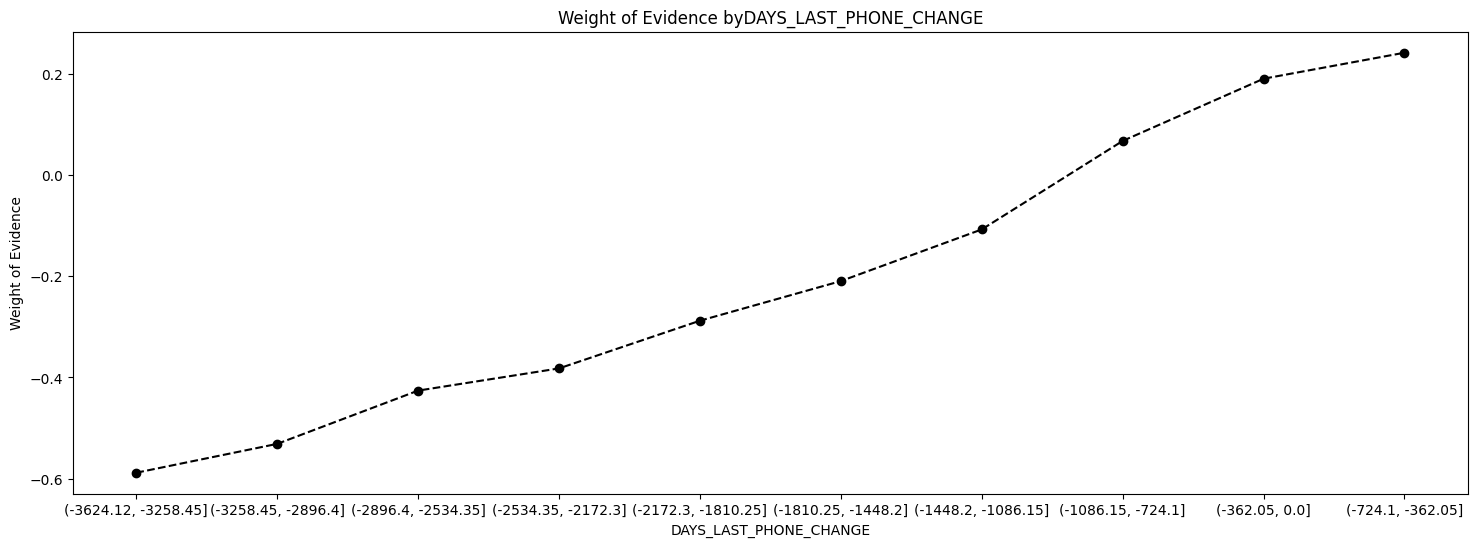

In [198]:
# fine cut of Days Last Phone Change
X_train_c4['DAYS_LAST_PHONE_CHANGE'] = pd.cut(X_train_c4['DAYS_LAST_PHONE_CHANGE'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_LAST_PHONE_CHANGE', y_train)
display(tempdata)
plot_woe(tempdata)

#### AMT_CREDIT_SUM_DEBT

,AMT_CREDIT_SUM_DEBT,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-898988.94, -655231.5]",36,0.000000,0.000034,0.0,36.0,0.000000,0.000037,-inf,NaN,NaN,inf
1,"(-655231.5, -413887.5]",30,0.000000,0.000028,0.0,30.0,0.000000,0.000031,-inf,0.000000,NaN,inf
2,"(-172543.5, 68800.5]",347485,0.062325,0.323961,21657.0,325828.0,0.234018,0.332454,-0.351101,0.062325,inf,inf
3,"(68800.5, 310144.5]",328306,0.092895,0.306080,30498.0,297808.0,0.329551,0.303864,0.081152,0.030570,0.432253,inf
4,"(310144.5, 551488.5]",108421,0.094548,0.101081,10251.0,98170.0,0.110769,0.100166,0.100614,0.001653,0.019462,inf
5,"(792832.5, 1034176.5]",48614,0.097729,0.045323,4751.0,43863.0,0.051338,0.044755,0.137224,0.003181,0.036609,inf
6,"(551488.5, 792832.5]",71161,0.100392,0.066344,7144.0,64017.0,0.077196,0.065319,0.167064,0.002663,0.029840,inf
7,"(1034176.5, 1275520.5]",34317,0.105137,0.031994,3608.0,30709.0,0.038987,0.031333,0.218538,0.004745,0.051474,inf
8,"(1275520.5, 1516864.5]",134178,0.109012,0.125094,14627.0,119551.0,0.158055,0.121982,0.259066,0.003875,0.040528,inf
9,"(-413887.5, -172543.5]",66,0.121212,0.000062,8.0,58.0,0.000086,0.000059,0.378938,0.012200,0.119872,inf


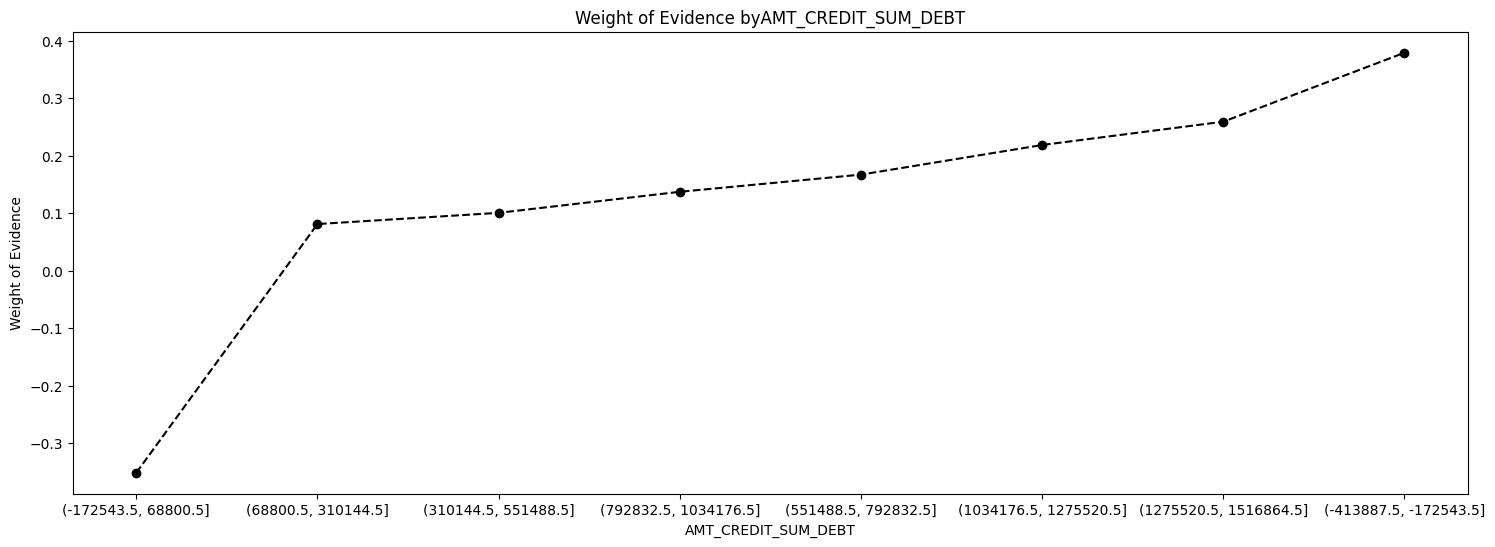

In [192]:
# fine cut of AMT_CREDIT_SUM_DEBT
X_train_c4['AMT_CREDIT_SUM_DEBT'] = pd.cut(X_train_c4['AMT_CREDIT_SUM_DEBT'], bins=10)
tempdata = woe_continous(X_train_c4, 'AMT_CREDIT_SUM_DEBT', y_train)
display(tempdata)
plot_woe(tempdata)

#### DAYS_LAST_DUE

,DAYS_LAST_DUE,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-1835.432, -1539.3]",129713,0.064843,0.120932,8411.0,121302.0,0.090886,0.123769,-0.308803,NaN,NaN,0.02781
1,"(-1246.1, -952.9]",50260,0.068981,0.046857,3467.0,46793.0,0.037463,0.047745,-0.242504,0.004138,0.066299,0.02781
2,"(-1539.3, -1246.1]",40047,0.071691,0.037336,2871.0,37176.0,0.031023,0.037932,-0.201063,0.002709,0.041441,0.02781
3,"(-952.9, -659.7]",66413,0.075256,0.061917,4998.0,61415.0,0.054007,0.062664,-0.148676,0.003566,0.052387,0.02781
4,"(-659.7, -366.5]",85446,0.078599,0.079661,6716.0,78730.0,0.072571,0.080331,-0.101592,0.003343,0.047085,0.02781
5,"(-366.5, -73.3]",107625,0.083075,0.100339,8941.0,98684.0,0.096614,0.100691,-0.041336,0.004476,0.060256,0.02781
6,"(806.3, 1099.5]",135291,0.085128,0.126132,11517.0,123774.0,0.124449,0.126291,-0.014693,0.002052,0.026642,0.02781
7,"(-73.3, 219.9]",457819,0.099653,0.426825,45623.0,412196.0,0.492987,0.420578,0.158853,0.014525,0.173546,0.02781
8,"(219.9, 513.1]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02781
9,"(513.1, 806.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02781


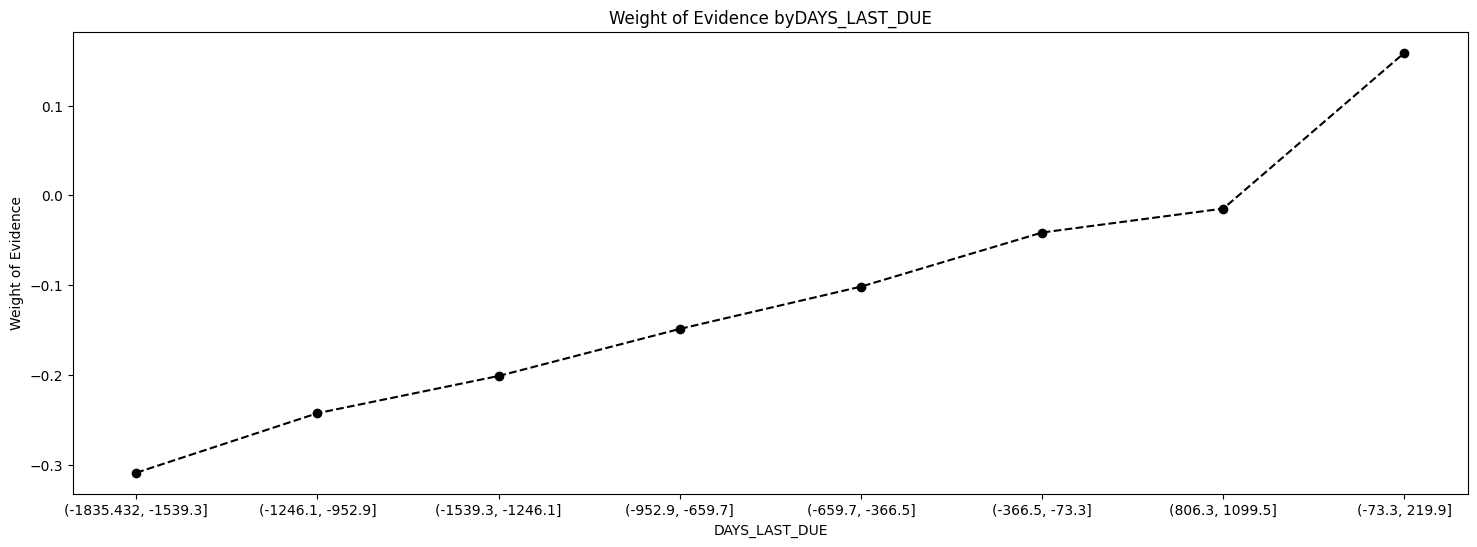

In [195]:
# fine cut of Days Last Due
X_train_c4['DAYS_LAST_DUE'] = pd.cut(X_train_c4['DAYS_LAST_DUE'], bins=10)
tempdata = woe_continous(X_train_c4, 'DAYS_LAST_DUE', y_train)
display(tempdata)
plot_woe(tempdata)

#### CNT_PAYMENT

,CNT_PAYMENT,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(4.0, 8.0]",145178,0.071691,0.135350,10408.0,134770.0,0.112465,0.137511,-0.201055,NaN,NaN,0.026735
1,"(8.0, 12.0]",311945,0.073734,0.290827,23001.0,288944.0,0.248541,0.294820,-0.170755,0.002043,0.030300,0.026735
2,"(20.0, 24.0]",87803,0.083630,0.081859,7343.0,80460.0,0.079346,0.082096,-0.034073,0.009896,0.136683,0.026735
3,"(16.0, 20.0]",50264,0.083897,0.046861,4217.0,46047.0,0.045568,0.046983,-0.030599,0.000267,0.003474,0.026735
4,"(12.0, 16.0]",9563,0.088571,0.008916,847.0,8716.0,0.009152,0.008893,0.028725,0.004674,0.059324,0.026735
5,"(28.0, 32.0]",11008,0.094386,0.010263,1039.0,9969.0,0.011227,0.010172,0.098718,0.005815,0.069993,0.026735
6,"(-0.04, 4.0]",340483,0.097130,0.317433,33071.0,307412.0,0.357354,0.313663,0.130408,0.002744,0.031689,0.026735
7,"(32.0, 36.0]",45471,0.104484,0.042393,4751.0,40720.0,0.051338,0.041548,0.211576,0.007355,0.081168,0.026735
8,"(36.0, 40.0]",70889,0.110948,0.066090,7865.0,63024.0,0.084987,0.064306,0.278847,0.006464,0.067271,0.026735
9,"(24.0, 28.0]",10,0.200000,0.000009,2.0,8.0,0.000022,0.000008,0.973645,0.089052,0.694799,0.026735


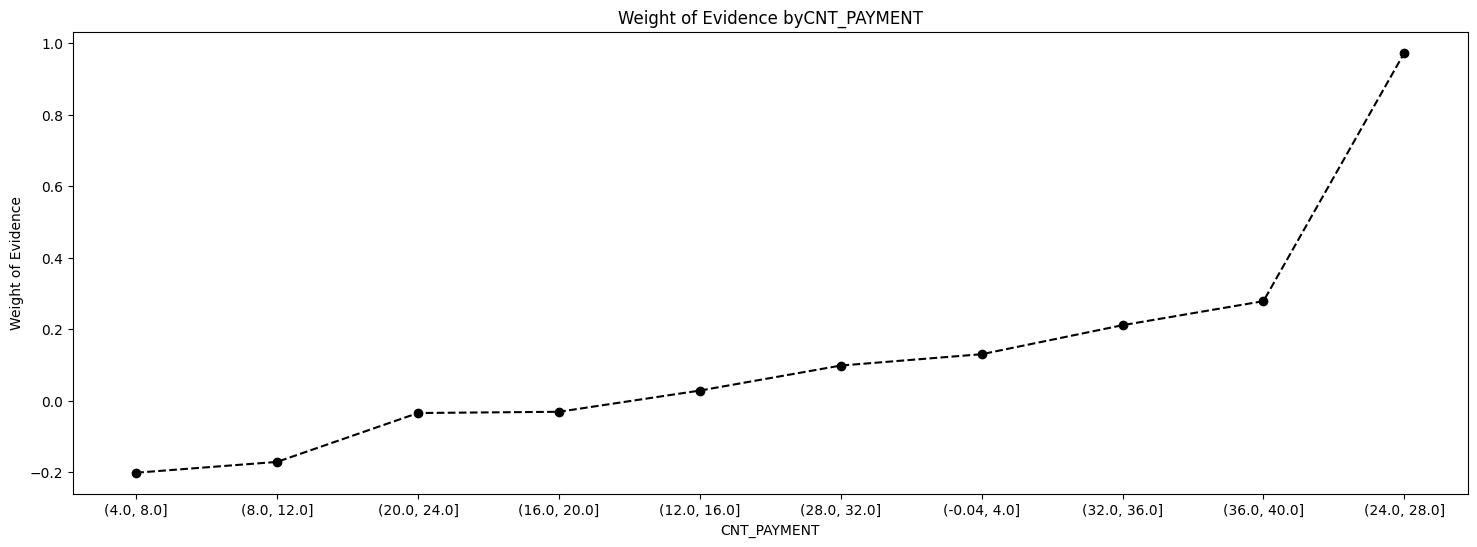

In [196]:
# fine cut of AGE 
X_train_c4['CNT_PAYMENT'] = pd.cut(X_train_c4['CNT_PAYMENT'], bins=10)
tempdata = woe_continous(X_train_c4, 'CNT_PAYMENT', y_train)
display(tempdata)
plot_woe(tempdata)
X_train_c4.drop(columns='DAYS_BIRTH', inplace=True)

In [199]:
X_train_c4.sample(10)

,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,CNT_PAYMENT,DAYS_LAST_DUE,CODE_GENDER:M,CODE_GENDER:XNA,NAME_INCOME_TYPE:Maternity leave,NAME_INCOME_TYPE:Others,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_CONTRACT_STATUS:Canceled,NAME_CONTRACT_STATUS:Refused,NAME_CONTRACT_STATUS:Unused offer
1313337,"(536400.0, 670500.0]","(0.0228, 0.0341]","(-2568.0, -1552.0]","(-4735.35, -3156.9]","(-5037.9, -4318.2]","(0.598, 0.684]","(-1810.25, -1448.2]","(551488.5, 792832.5]","(-0.04, 4.0]","(-73.3, 219.9]",0,0,0,0,0,0,0,0,0,0,1,1,0,0
69155,"(268200.0, 402300.0]","(0.0116, 0.0228]","(-1552.0, -536.0]","(-9470.7, -7892.25]","(-4318.2, -3598.5]","(0.684, 0.769]","(-362.05, 0.0]","(68800.5, 310144.5]","(20.0, 24.0]","(-659.7, -366.5]",0,0,0,0,0,1,0,0,0,0,1,0,0,0
803040,"(670500.0, 804600.0]","(0.000234, 0.0116]","(2512.0, 3528.0]","(-4735.35, -3156.9]","(-4318.2, -3598.5]","(0.598, 0.684]","(-3258.45, -2896.4]","(310144.5, 551488.5]","(8.0, 12.0]","(-1835.432, -1539.3]",0,0,0,0,1,0,0,0,0,0,1,0,0,0
1098785,"(804600.0, 938700.0]","(0.0116, 0.0228]","(-1552.0, -536.0]","(-1578.45, 0.0]","(-4318.2, -3598.5]","(0.513, 0.598]","(-1810.25, -1448.2]","(792832.5, 1034176.5]","(36.0, 40.0]","(-659.7, -366.5]",0,0,0,0,0,0,1,0,0,0,1,0,0,0
1098092,"(402300.0, 536400.0]","(0.000234, 0.0116]","(-3584.0, -2568.0]","(-4735.35, -3156.9]","(-5037.9, -4318.2]","(0.598, 0.684]","(-1810.25, -1448.2]","(1275520.5, 1516864.5]","(36.0, 40.0]","(806.3, 1099.5]",0,0,0,0,0,0,1,0,0,0,1,0,0,0
1086130,"(134100.0, 268200.0]","(0.0116, 0.0228]","(-2568.0, -1552.0]","(-3156.9, -1578.45]","(-4318.2, -3598.5]","(0.598, 0.684]","(-1810.25, -1448.2]","(-172543.5, 68800.5]","(8.0, 12.0]","(-73.3, 219.9]",1,0,0,0,0,0,1,0,0,0,1,0,1,0
92158,"(134100.0, 268200.0]","(0.000234, 0.0116]","(-3584.0, -2568.0]","(-1578.45, 0.0]","(-1439.4, -719.7]","(0.598, 0.684]","(-1086.15, -724.1]","(1275520.5, 1516864.5]","(8.0, 12.0]","(-659.7, -366.5]",0,0,0,0,0,0,1,1,0,0,0,0,0,0
782172,"(268200.0, 402300.0]","(0.0116, 0.0228]","(2512.0, 3528.0]","(-11049.15, -9470.7]","(-5037.9, -4318.2]","(0.769, 0.855]","(-2896.4, -2534.35]","(-172543.5, 68800.5]","(-0.04, 4.0]","(-73.3, 219.9]",0,0,0,0,1,0,0,1,0,0,0,0,0,1
909613,"(1072800.0, 1206900.0]","(0.0341, 0.0453]","(-6642.16, -5616.0]","(-1578.45, 0.0]","(-719.7, 0.0]","(0.598, 0.684]","(-1810.25, -1448.2]","(68800.5, 310144.5]","(-0.04, 4.0]","(-1246.1, -952.9]",1,0,0,0,0,0,1,0,0,0,1,0,0,0
1243856,"(402300.0, 536400.0]","(0.000234, 0.0116]","(-536.0, 480.0]","(-4735.35, -3156.9]","(-4318.2, -3598.5]","(0.427, 0.513]","(-1448.2, -1086.15]","(310144.5, 551488.5]","(-0.04, 4.0]","(-73.3, 219.9]",1,0,0,0,0,0,1,0,0,0,1,1,0,0


In [96]:
X_train_c4.select_dtypes('object').columns

Index([], dtype='object')

In [200]:
# Update the binning to data test
X_test_c3['AMT_GOODS_PRICE_curr'] = pd.cut(X_test_c3['AMT_GOODS_PRICE_curr'], bins=10)
X_test_c3['REGION_POPULATION_RELATIVE'] = pd.cut(X_test_c3['REGION_POPULATION_RELATIVE'], bins=5)
X_test_c3['DAYS_EMPLOYED'] = pd.cut(X_test_c3['DAYS_EMPLOYED'], bins=10)
X_test_c3['DAYS_REGISTRATION'] = pd.cut(X_test_c3['DAYS_REGISTRATION'], bins=10)
X_test_c3['DAYS_ID_PUBLISH'] = pd.cut(X_test_c3['DAYS_ID_PUBLISH'], bins=10)
X_test_c3['EXT_SOURCE_2'] = pd.cut(X_test_c3['EXT_SOURCE_2'], bins=10)
X_test_c3['DAYS_LAST_PHONE_CHANGE'] = pd.cut(X_test_c3['DAYS_LAST_PHONE_CHANGE'], bins=10)
X_test_c3['AMT_CREDIT_SUM_DEBT'] = pd.cut(X_test_c3['AMT_CREDIT_SUM_DEBT'], bins=10)
X_test_c3['CNT_PAYMENT'] = pd.cut(X_test_c3['CNT_PAYMENT'], bins=10)
X_test_c3['DAYS_LAST_DUE'] = pd.cut(X_test_c3['DAYS_LAST_DUE'], bins=10)

## Calculate WoE

In [203]:
def calculate_woe_iv(data, feature, target):
    lst = []
    for i in range(data[feature].nunique()):
        val = list(data[feature].unique())[i]
        total = data[data[feature] == val].count()[feature]
        good = data[data[feature] == val][data[target] == 0].count()[feature]
        bad = data[data[feature] == val][data[target] == 1].count()[feature]
        lst.append({
            'Value': val,
            'All': total,
            'Good': good,
            'Bad': bad
        })
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    dset = dset.sort_values(by='WoE')
    return dset, iv

# df_woe_iv, iv = calculate_woe_iv(X_train_c4, 'AMT_INCOME_TOTAL', y_train)

In [102]:
train = pd.concat([X_train_c4, y_train], axis=1)
sample = train.sample(frac=0.25, random_state=1103)

# c = toad.transform.Combiner()
# c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='dt', n_bins=None, empty_separate=True)

# intialize the WOE transformer
td = toad.transform.WOETransformer()

# Transform the data into WoE values
td.fit(sample.drop(columns='TARGET'), sample['TARGET'])

In [103]:
# transform the data
X_train_c5 = td.transform(X_train_c4)

In [109]:
X_test_c4 = td.transform(X_test_c3)

In [117]:
X_train_c5

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AGE,NAME_CONTRACT_TYPE_curr:Revolving loans,CODE_GENDER:M,CODE_GENDER:XNA,FLAG_OWN_CAR:Y,FLAG_OWN_REALTY:Y,NAME_TYPE_SUITE:Unaccompanied,NAME_INCOME_TYPE:Maternity leave,NAME_INCOME_TYPE:Others,NAME_INCOME_TYPE:Pensioner,NAME_INCOME_TYPE:State servant,NAME_INCOME_TYPE:Working,NAME_EDUCATION_TYPE:Higher education,NAME_EDUCATION_TYPE:Incomplete higher,NAME_EDUCATION_TYPE:Lower secondary,NAME_EDUCATION_TYPE:Secondary / secondary special,NAME_FAMILY_STATUS:Married,NAME_FAMILY_STATUS:Separated,NAME_FAMILY_STATUS:Single / not married,NAME_FAMILY_STATUS:Widow,NAME_HOUSING_TYPE:House / apartment,NAME_HOUSING_TYPE:Municipal apartment,NAME_HOUSING_TYPE:Office apartment,NAME_HOUSING_TYPE:Rented apartment,NAME_HOUSING_TYPE:With parents,WEEKDAY_APPR_PROCESS_START_curr:MONDAY,WEEKDAY_APPR_PROCESS_START_curr:SATURDAY,WEEKDAY_APPR_PROCESS_START_curr:SUNDAY,WEEKDAY_APPR_PROCESS_START_curr:THURSDAY,WEEKDAY_APPR_PROCESS_START_curr:TUESDAY,WEEKDAY_APPR_PROCESS_START_curr:WEDNESDAY,NAME_CONTRACT_TYPE_prev:Consumer loans,NAME_CONTRACT_TYPE_prev:Revolving loans,NAME_CONTRACT_TYPE_prev:XNA,WEEKDAY_APPR_PROCESS_START_prev:MONDAY,WEEKDAY_APPR_PROCESS_START_prev:SATURDAY,WEEKDAY_APPR_PROCESS_START_prev:SUNDAY,WEEKDAY_APPR_PROCESS_START_prev:THURSDAY,WEEKDAY_APPR_PROCESS_START_prev:TUESDAY,WEEKDAY_APPR_PROCESS_START_prev:WEDNESDAY,FLAG_LAST_APPL_PER_CONTRACT:Y,NAME_CONTRACT_STATUS:Canceled,NAME_CONTRACT_STATUS:Refused,NAME_CONTRACT_STATUS:Unused offer,NAME_PAYMENT_TYPE:Cashless from the account of the employer,NAME_PAYMENT_TYPE:Non-cash from your account,NAME_PAYMENT_TYPE:XNA,NAME_CLIENT_TYPE:Refreshed,NAME_CLIENT_TYPE:Repeater,NAME_CLIENT_TYPE:XNA,NAME_PORTFOLIO:Cars,NAME_PORTFOLIO:Cash,NAME_PORTFOLIO:POS,NAME_PORTFOLIO:XNA,CHANNEL_TYPE:Car dealer,CHANNEL_TYPE:Channel of corporate sales,CHANNEL_TYPE:Contact center,CHANNEL_TYPE:Country-wide,CHANNEL_TYPE:Credit and cash offices,CHANNEL_TYPE:Regional / Local,CHANNEL_TYPE:Stone,NAME_YIELD_GROUP:low_action,NAME_YIELD_GROUP:low_normal,NAME_YIELD_GROUP:middle
929990,-0.048041,0.042810,0.055552,-0.168980,0.023054,0.109796,-0.380705,-0.349149,-0.077269,0.0,0.0,0.0,0.0,-0.132135,0.0,-0.049800,0.0,0.0,-0.026332,0.0,0.0,0.0,0.0,0.0,0.0,1.262513,-0.048015,0.0,-0.046024,0.0,0.183465,-0.115783,-0.357242,0.128772,0.077507,0.072921,0.077542,-0.020458,0.0,0.121449,0.072125,0.150002,0.168348,-0.313573,0.031442,-0.139591,0.000053,0.036433,-0.016888,0.014254,-0.00013,-0.000403,-0.384416,0.020908,-0.231108,-0.408154,-0.000814,-0.003003,-0.312297,-0.049339,0.000341,-0.033236,0.016029,-0.036425,-0.002818,0.001765,-0.007339,-0.024636,0.012965,-0.001912,-0.002159,-0.016067,-0.009771,-0.006980,0.093788,-0.02929,-0.000127,-0.005042,-0.038393,0.009759,-0.005509,-0.001107,0.002383,-0.001985,0.082949,-0.090639,0.000015,0.000142,0.000214,0.120528,0.016205,0.010664,-0.000388,0.000008,-0.015086,0.098303,0.141661,0.00002,0.001086,-0.010281,0.025054,0.048490,0.011902,0.023574,0.01522,0.046162,0.051097
299559,-0.048041,0.042810,-0.099432,0.138194,-0.179893,0.048742,0.290737,-0.263639,-0.255479,0.0,0.0,0.0,0.0,0.048053,0.0,-0.049800,0.0,0.0,-0.028053,0.0,0.0,0.0,0.0,0.0,0.0,0.751687,-0.048015,0.0,-0.046024,0.0,0.093838,

In [105]:
# train = pd.concat([X_train_c4, y_train], axis=1)
# sample = train.sample(frac=0.25, random_state=1103)

# c = toad.transform.Combiner()
# c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='dt', n_bins=None, empty_separate=True)

# # intialize the WOE transformer
# td = toad.transform.WOETransformer()

# # Transform the data into WoE values
# Xtrain_selected_woe = td.fit_transform(c.transform(X_train_c4), y_train['TARGET'])

# # transform test set
# Xtest_selected_woe = td.fit_transform(c.transform(X_test_c3), y_test['TARGET'])

## Model Building

In [106]:
lr = LogisticRegression()
lr.fit(X_train_c5, y_train)

y_pred = lr.predict(X_test_c3)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- DAYS_BIRTH
- NAME_PRODUCT_TYPE


## WoE Binning and Feature Engineering

In [125]:
X_train_c3.select_dtypes('number')

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,CHANNEL_TYPE:Channel of corporate sales,CHANNEL_TYPE:Contact center,CHANNEL_TYPE:Country-wide,CHANNEL_TYPE:Credit and cash offices,CHANNEL_TYPE:Regional / Local,CHANNEL_TYPE:Stone,NAME_YIELD_GROUP:high,NAME_YIELD_GROUP:low_action,NAME_YIELD_GROUP:low_normal,NAME_YIELD_GROUP:middle
929990,0.0,157500.0,216144.0,12199.5,171000.0,0.022800,-21310.0,3528.0,-9977.0,-4143.0,...,0,0,0,1,0,0,0,0,0,0
299559,0.0,157500.0,900000.0,26316.0,900000.0,0.006305,-21609.0,-1010.0,-12360.0,-4790.0,...,0,0,0,1,0,0,0,0,0,0
428457,0.0,189000.0,1506816.0,47443.5,1341000.0,0.011703,-19394.0,-2579.0,-11456.0,-2943.0,...,0,0,0,1,0,0,0,0,0,0
7003,0.0,202500.0,254700.0,16713.0,225000.0,0.018801,-9142.0,-746.0,-4016.0,-1805.0,...,0,0,1,0,0,0,1,0,0,0
412202,1.0,135000.0,312768.0,16096.5,270000.0,0.019689,-12550.0,-1764.0,-3255.0,-3867.0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,1.0,157500.0,270000.0,13500.0,270000.0,0.031329,-10380.0,-921.0,-4866.0,-3042.0,...,0,0,1,0,0,0,1,0,0,0
1419947,0.0,108000.0,405000.0,14544.0,405000.0,0.025164,-20659.0,3528.0,-4696.0,-4150.0,...,0,0,0,1,0,0,0,0,0,0
734247,2.5,90000.0,959598.0,28057.5,801000.0,0.015221,-14070.0,-6632.0,-8163.0,-5151.0,...,0,0,0,1,0,0,0,0,0,0
509863,0.0,67500.0,474363.0,28795.5,409500.0,0.002134,-10528.0,-342.0,-4236.0,-185.0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
X_trainbin = X_train_c3.copy()
X_trainbin['AMT_INCOME_TOTAL'] = pd.cut(X_trainbin['AMT_INCOME_TOTAL'], bins=20)


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
X_train_cp = X_train_c3.copy()

discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
train_binned = discretizer.fit_transform(X_train_cp)

woe = np.log((train_binned.sum(axis=0) / 
              train_binned.sum()) / 
              ((1 - train_binned).sum(axis=0) / 
               (1 - train_binned).sum()))

base_score = 600
base_odds = 1.0



## Model Building

## aa

In [121]:
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     # Fit the model to the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the training data
#     y_train_pred = model.predict(X_train)
    
#     # Make predictions on the testing data
#     y_test_pred = model.predict(X_test)
    
#     # Calculate the accuracy for the training and testing data
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Calculate the precision for the training and testing data
#     train_precision = precision_score(y_train, y_train_pred)
#     test_precision = precision_score(y_test, y_test_pred)
    
#     # Calculate the recall for the training and testing data
#     train_recall = recall_score(y_train, y_train_pred)
#     test_recall = recall_score(y_test, y_test_pred)
    
#     # Calculate the F1 score for the training and testing data
#     train_f1 = f1_score(y_train, y_train_pred)
#     test_f1 = f1_score(y_test, y_test_pred)

#     # Calculate the ROC AUC for the training and testing data
#     train_roc_auc = roc_auc_score(y_train, y_train_pred)
#     test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
#     return {
#         'model': model.__class__.__name__,
#         'train_recall': round(train_recall, 2),
#         'test_recall': round(test_recall, 2),
#         'train_roc_auc': round(train_roc_auc, 2),
#         'test_roc_auc': round(test_roc_auc, 2)
#     }

In [60]:
# import xgboost model
from xgboost import XGBClassifier

# import gradient boosting model
from sklearn.ensemble import GradientBoostingClassifier

lr = LogisticRegression(random_state=1103, class_weight='balanced')
xgb = XGBClassifier(random_state=1103)
gbc = GradientBoostingClassifier(random_state=1103)

models = [lr, xgb]

results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# Convert the results to a DataFrame
df_model = pd.DataFrame(results)

In [61]:
df_model

,model,train_recall,test_recall,train_roc_auc,test_roc_auc
0,LogisticRegression,0.64,0.65,0.64,0.58
1,XGBClassifier,0.07,0.06,0.53,0.53


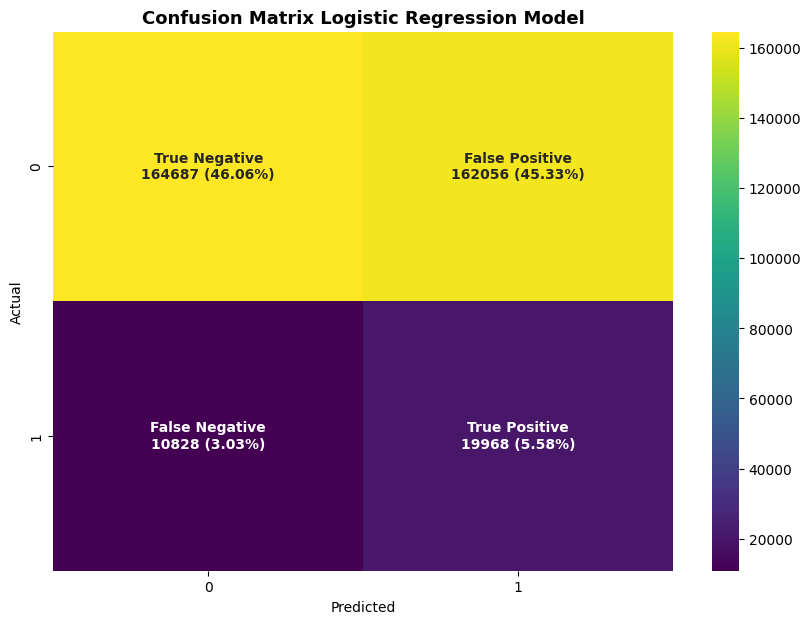

In [53]:
# Assuming X_test is your test dataset and model is your Gradient Boosting model
y_pred = lr.predict(X_test_scaled)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the percentage of each category
percentage_matrix = cnf_matrix / cnf_matrix.sum()

# Define the labels
labels = np.array([['True Negative', 'False Positive'],
                   ['False Negative', 'True Positive']])

# Create labels with both count and percentage
new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
                          for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
             ).reshape(2,2)

# Plot confusion matrix using a heatmap
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')  # Change figure color

sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Change label colors
plt.gca().xaxis.label.set_color('black')
plt.gca().yaxis.label.set_color('black')

plt.show()

## WoE and IV

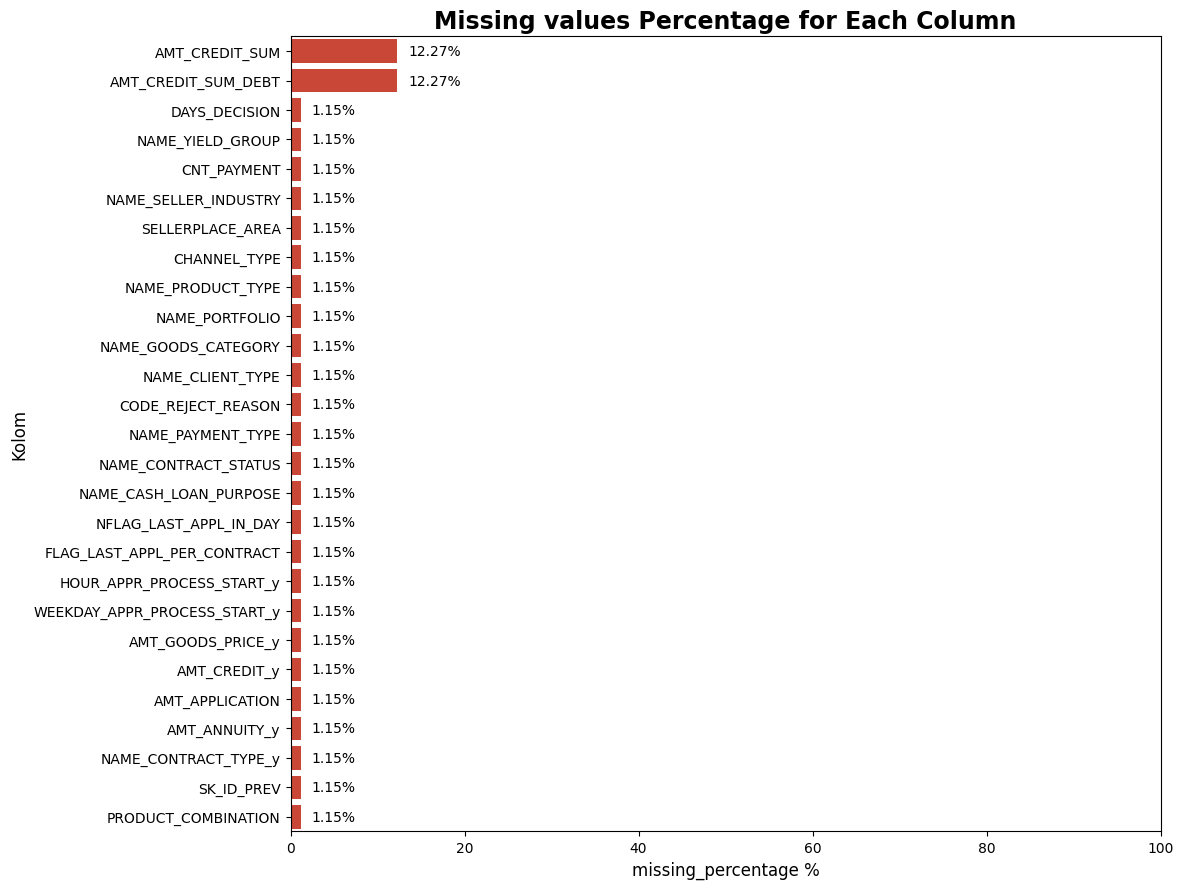

In [ ]:
ms.plot_missing_percentage(train_clean2)